In [6]:
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
df = pd.read_csv("kidiq.csv", sep=";")

kid_score Child's IQ score
        mom_hs Indicator for whether the mother has a high school degree
        mom_iq Mother's IQ score
        mom_work 1 = did not work in first three years of child's life
                 2 = worked in 2nd or 3rd year of child's life
                 3 = worked part-time in first year of child's life
                 4 = worked full-time in first year of child's life
        mom_age Mother's age


In [4]:
df

,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,1,121.117529,4,27
1,98,1,89.361882,4,25
2,85,1,115.443165,4,27
3,83,1,99.449639,3,25
4,115,1,92.745710,4,27
...,...,...,...,...,...
429,94,0,84.877412,4,21
430,76,1,92.990392,4,23
431,50,0,94.859708,2,24
432,88,1,96.856624,2,21


In [14]:
# import plotly.express as px


# fig = px.scatter(df, x="kid_score", y="mom_iq")
# fig.show()

In [21]:
df.corr()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
kid_score,1.000000,0.236916,0.448276,0.087528,0.091998
mom_hs,0.236916,1.000000,0.282709,0.253910,0.214528
mom_iq,0.448276,0.282709,1.000000,0.114803,0.091608
mom_work,0.087528,0.253910,0.114803,1.000000,0.135598
mom_age,0.091998,0.214528,0.091608,0.135598,1.000000


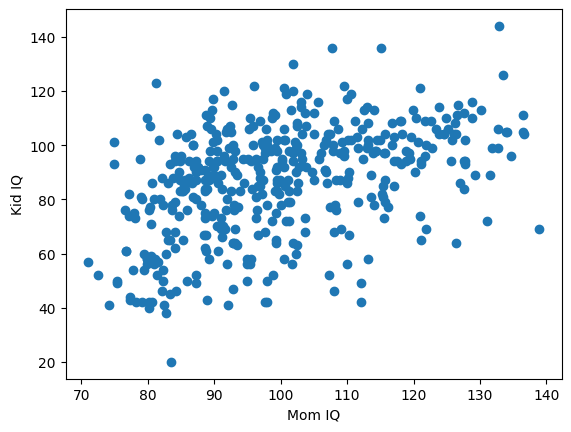

In [25]:
plt.scatter(df["mom_iq"], df["kid_score"])
plt.ylabel("Kid IQ")
plt.xlabel("Mom IQ")
plt.show()

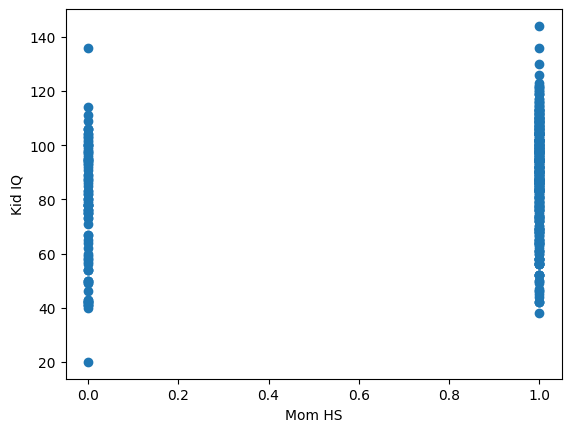

In [26]:
plt.scatter( df["mom_hs"], df["kid_score"])
plt.ylabel("Kid IQ")
plt.xlabel("Mom HS")
plt.show()

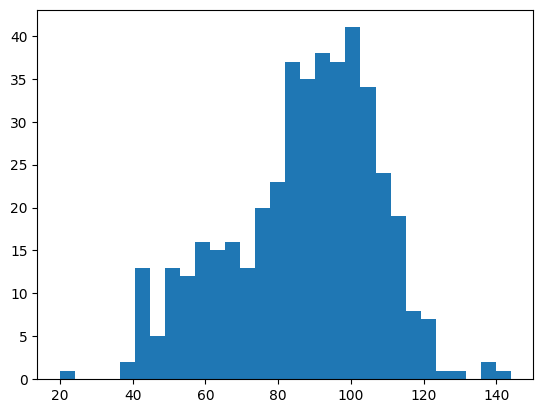

In [29]:
plt.hist(df["kid_score"], bins=30)
plt.show()

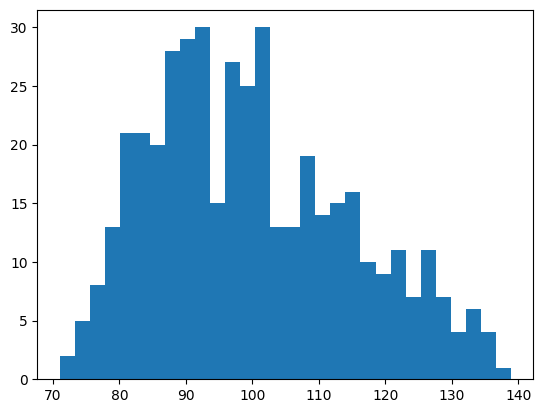

In [31]:
plt.hist(df["mom_iq"], bins=30)
plt.show()

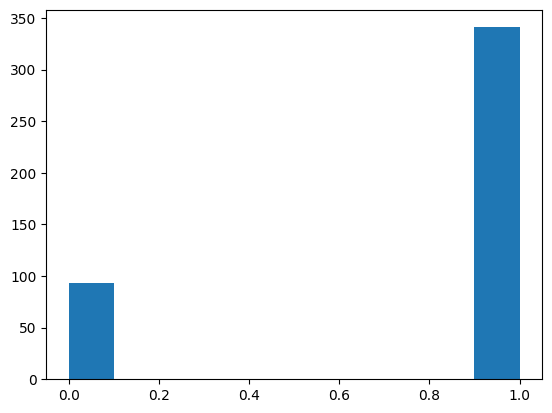

In [32]:
plt.hist(df["mom_hs"])
plt.show()